# Setup

In [47]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import plotting

import warnings
warnings.filterwarnings("ignore")

In [48]:
with open("data/hopsworks-token.txt") as f:
    hopsworks_api_key = f.read().rstrip()

In [49]:
project = hopsworks.login(api_key_value=hopsworks_api_key)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160342
Connected. Call `.close()` to terminate connection gracefully.


In [50]:
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1,
)
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)

# Feature view

In [51]:
selected_features = air_quality_fg.select(["pm25", "lagged"]).join(weather_fg.select_all(), on=["city"])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 


,pm25,lagged,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2.31,2.906667,2019-12-12 00:00:00+00:00,1.754333,0.6,19.022177,204.584427,reutlingen
1,1.18,3.403333,2019-12-13 00:00:00+00:00,3.264750,10.2,31.367548,214.353134,reutlingen
2,1.02,2.920000,2019-12-14 00:00:00+00:00,6.021000,5.5,40.377815,231.529892,reutlingen
3,1.05,1.503333,2019-12-15 00:00:00+00:00,9.654333,3.5,29.304090,220.615494,reutlingen
4,4.51,1.083333,2019-12-16 00:00:00+00:00,8.225167,0.3,12.727921,190.565826,reutlingen
5,6.18,2.193333,2019-12-17 00:00:00+00:00,8.741834,0.0,12.879752,206.666275,reutlingen
6,4.59,3.913333,2019-12-18 00:00:00+00:00,10.056417,4.2,15.408671,193.553787,reutlingen
7,4.16,5.093333,2019-12-19 00:00:00+00:00,6.771000,0.0,10.495713,200.656357,reutlingen
8,4.48,4.976667,2019-12-20 00:00:00+00:00,7.200165,2.9,19.453327,209.708923,reutlingen
9,2.57,4.410000,2019-12-21 00:00:00+00:00,4.510583,1.7,14.799459,196.180450,reutlingen


In [52]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_view",
    description="Weather features with air quality as the target",
    version=1,
    labels=["pm25"],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160342/fs/1151045/fv/air_quality_view/version/1


In [53]:
# Note: we have ~18k data points, so a year would be 20%.
# January is a good start but March yields much better results, so we take a very small test set.
start_date_test_data = "2024-03-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [54]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


In [55]:
X_train

,lagged,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2.906667,2019-12-12 00:00:00+00:00,1.754333,0.6,19.022177,204.584427,reutlingen
1,3.403333,2019-12-13 00:00:00+00:00,3.264750,10.2,31.367548,214.353134,reutlingen
2,2.920000,2019-12-14 00:00:00+00:00,6.021000,5.5,40.377815,231.529892,reutlingen
3,1.503333,2019-12-15 00:00:00+00:00,9.654333,3.5,29.304090,220.615494,reutlingen
4,1.083333,2019-12-16 00:00:00+00:00,8.225167,0.3,12.727921,190.565826,reutlingen
...,...,...,...,...,...,...,...
1529,1.300000,2024-02-25 00:00:00+00:00,5.471001,0.4,14.182355,181.705719,reutlingen
1530,1.666667,2024-02-26 00:00:00+00:00,7.471000,2.1,11.298495,76.902954,reutlingen
1531,2.053333,2024-02-27 00:00:00+00:00,6.633501,0.1,17.057314,32.642391,reutlingen
1532,5.876667,2024-02-28 00:00:00+00:00,5.418916,0.1,7.289445,38.945835,reutlingen


In [56]:
train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [57]:
y_train

,pm25
0,2.31
1,1.18
2,1.02
3,1.05
4,4.51
...,...
1529,1.90
1530,2.43
1531,13.30
1532,18.50


# Model training

In [58]:
xgbr = XGBRegressor()
xgbr.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [59]:
y_pred = xgbr.predict(test_features)
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("MSE is", mse, ", R^2 is", r2)

MSE is 5.432439970478578 , R^2 is 0.27649946106040124


In [60]:
test_df = y_test
test_df["predicted_pm25"] = y_pred
test_df["date"] = X_test["date"]
test_df = test_df.sort_values(by=["date"])
test_df.head(5)

,pm25,predicted_pm25,date
1534,12.52,7.706391,2024-03-01 00:00:00+00:00
1535,8.47,11.842547,2024-03-02 00:00:00+00:00
1536,9.60,8.861856,2024-03-03 00:00:00+00:00
1537,14.09,8.856424,2024-03-04 00:00:00+00:00
1538,9.13,5.105376,2024-03-05 00:00:00+00:00


In [61]:
model_dir = "aqm"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = os.path.join(model_dir, "images")
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

<module 'matplotlib.pyplot' from '/Users/ph/Programming/KTH/AirQualityPrediction/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

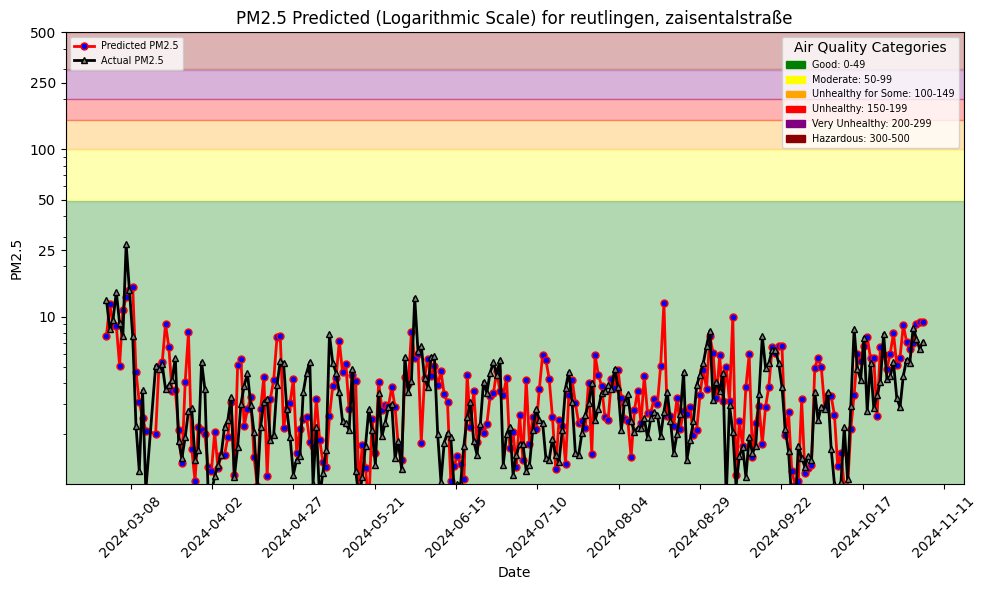

In [62]:
hindcast_path = os.path.join(images_dir, "pm25_hindcast.png")
plotting.plot_air_quality_forecast("reutlingen", "zaisentalstraße", test_df, hindcast_path, hindcast=True)

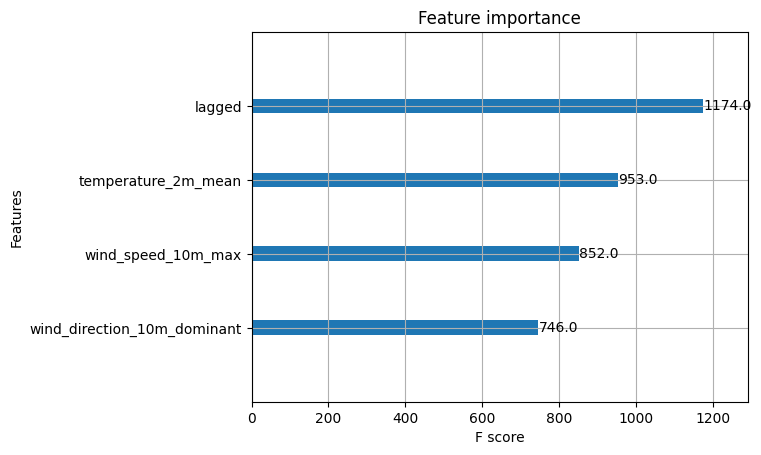

In [63]:
plot_importance(xgbr, max_num_features=4)
importance_path = os.path.join(images_dir, "feature_importance.png")
plt.savefig(importance_path)
plt.show()

# Hopsworks registry

In [64]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
schema_dict = model_schema.to_dict()

In [65]:
xgbr.save_model(os.path.join(model_dir, "model.json"))

In [66]:
res_dict = {
    "MSE": str(mse),
    "R squared": str(r2),
}

In [67]:
mr = project.get_model_registry()
aq_model = mr.python.create_model(
    name="air_quality_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Air Quality (PM2.5) predictor",
)
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/487831 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19072 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138689 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/143 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/714 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1160342/models/air_quality_model/1


Model(name: 'air_quality_model', version: 1)